# Conductance data

In [2]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import numpy as np
from numpy import NaN

def clean_outliers(df_timeseries):
    # Determine Interquartile Range (IQR)
    Q1 = np.percentile(df_timeseries, 25, interpolation = 'midpoint')
    Q3 = np.percentile(df_timeseries, 75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    
    # Get upper and lower outliers indices
    upper_outliers_indices = df_timeseries >= (Q3+1.5*IQR)
    lower_outliers_indices = df_timeseries <= (Q1-1.5*IQR)
    
    # Extract outlier values
    upper_outliers = df_timeseries[np.where(upper_outliers_indices)[0]].values
    outliers = np.concatenate([upper_outliers, np.zeros(1)])
    
    # Replace outliers with NaNs and fill in via interpolation
    df_with_NaNs = df_timeseries.replace(outliers, NaN)
    df_interpolated = df_with_NaNs.interpolate(method='linear', axis=0).ffill().bfill()
    
    return df_interpolated

In [4]:
dirnames = !ls -d data/cWza*_conformation*_[0-9][0-9][0-9][0-9]

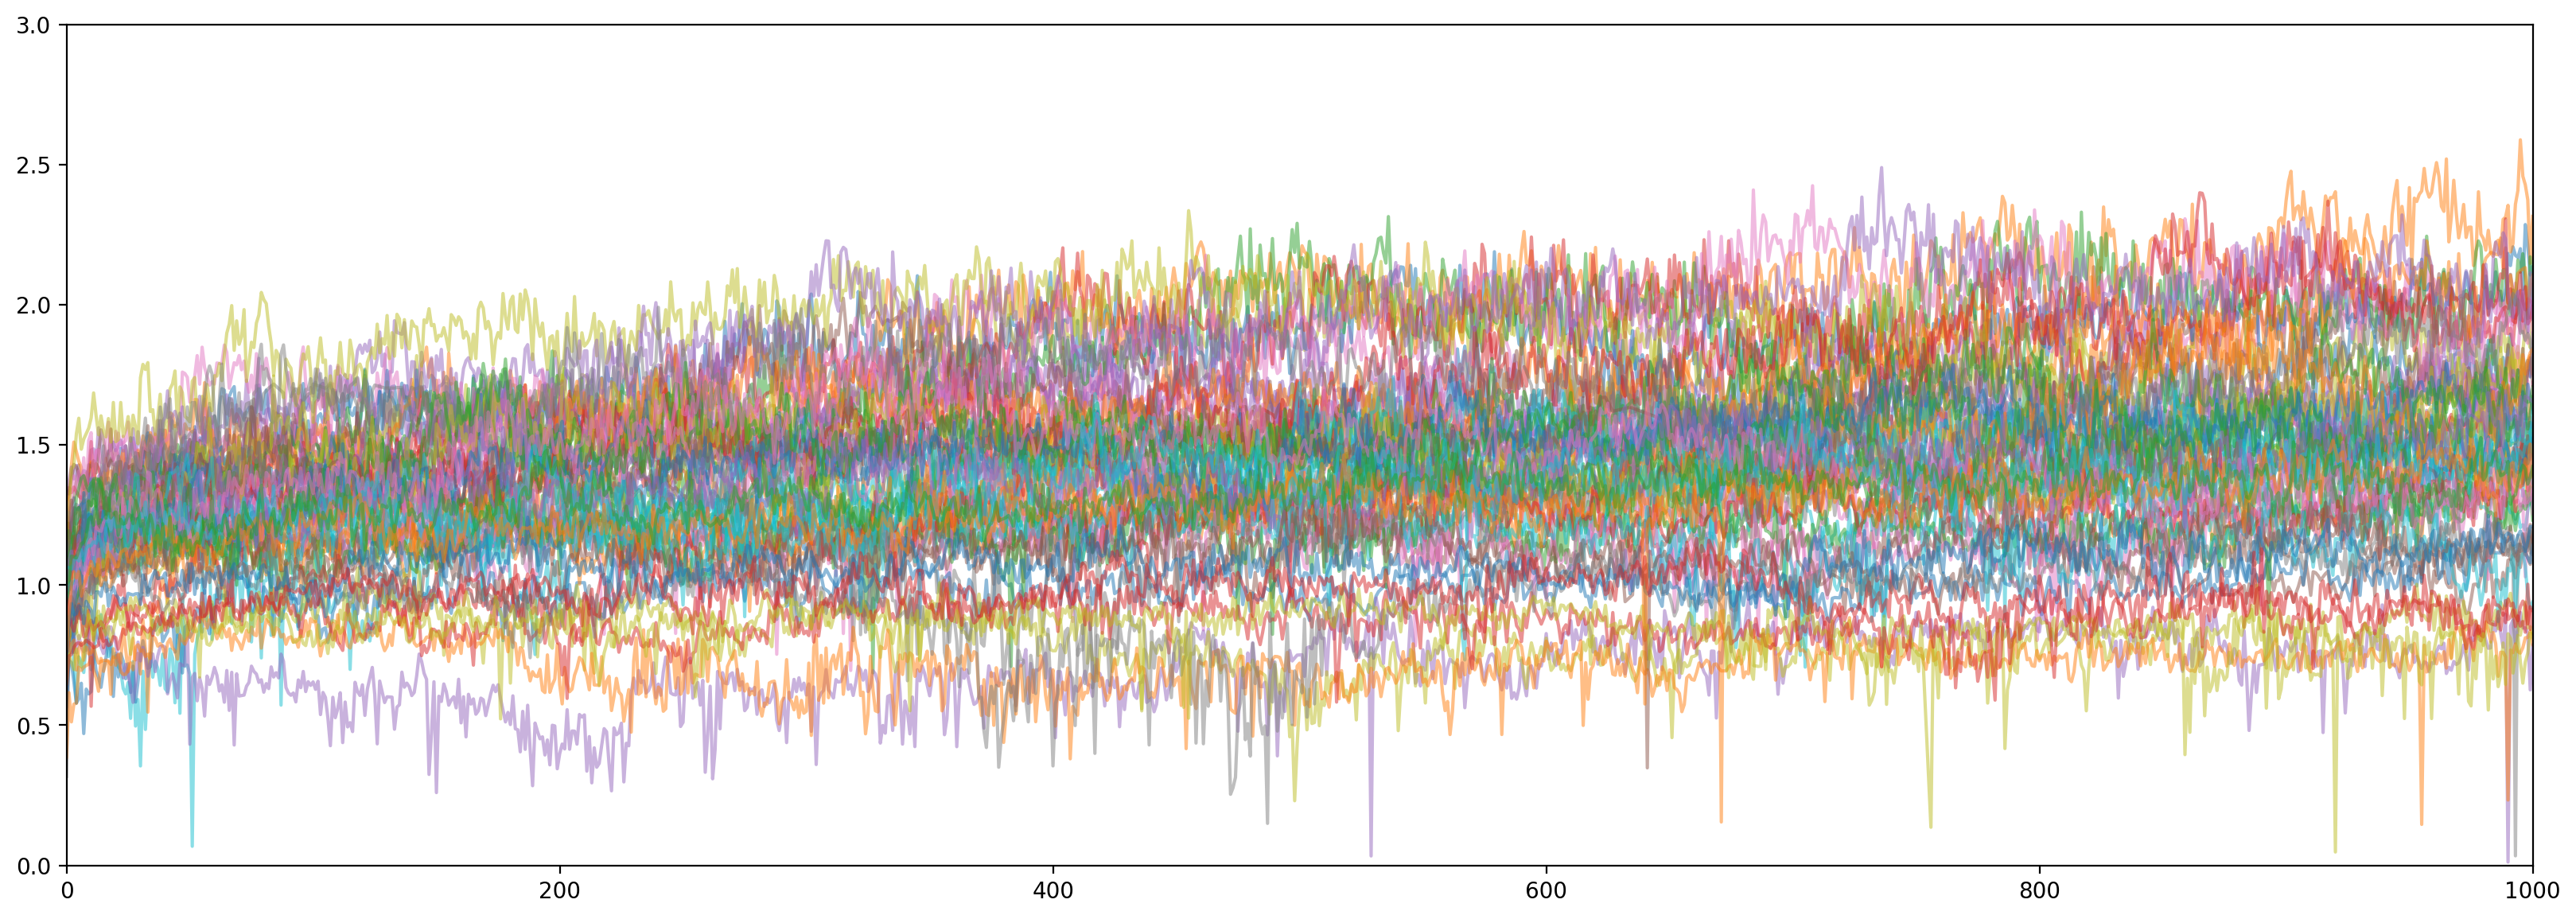

In [5]:
fig,ax = plt.subplots(1,1,figsize=(20,7),dpi=200)

HOLE_data = {}
for outdir in dirnames:
    model_name = outdir.split('/')[-1]

    with open(os.path.join(outdir, "md_100ns.hole.pickle"),'rb') as fp:
        hdata = pickle.load(fp)
        
    y = [list(hdata.values())[i][1][1] for i in range(len(hdata.keys())-1)]
    if len(y) > 0:
        df = pd.DataFrame({'test':y})
        df_new = clean_outliers(df['test'])
        df_new.plot(ax=ax,lw=1.5,alpha=0.5)
        HOLE_data[model_name] = np.array(df_new)
            
    else:
        print("ERROR: No data for model", outdir)
    
ax.set_xlim(0,1000)
ax.set_ylim(0,3)
plt.show()

In [6]:
X = HOLE_data
data_matrix = np.array([np.array(X[key]) for key in X.keys()])

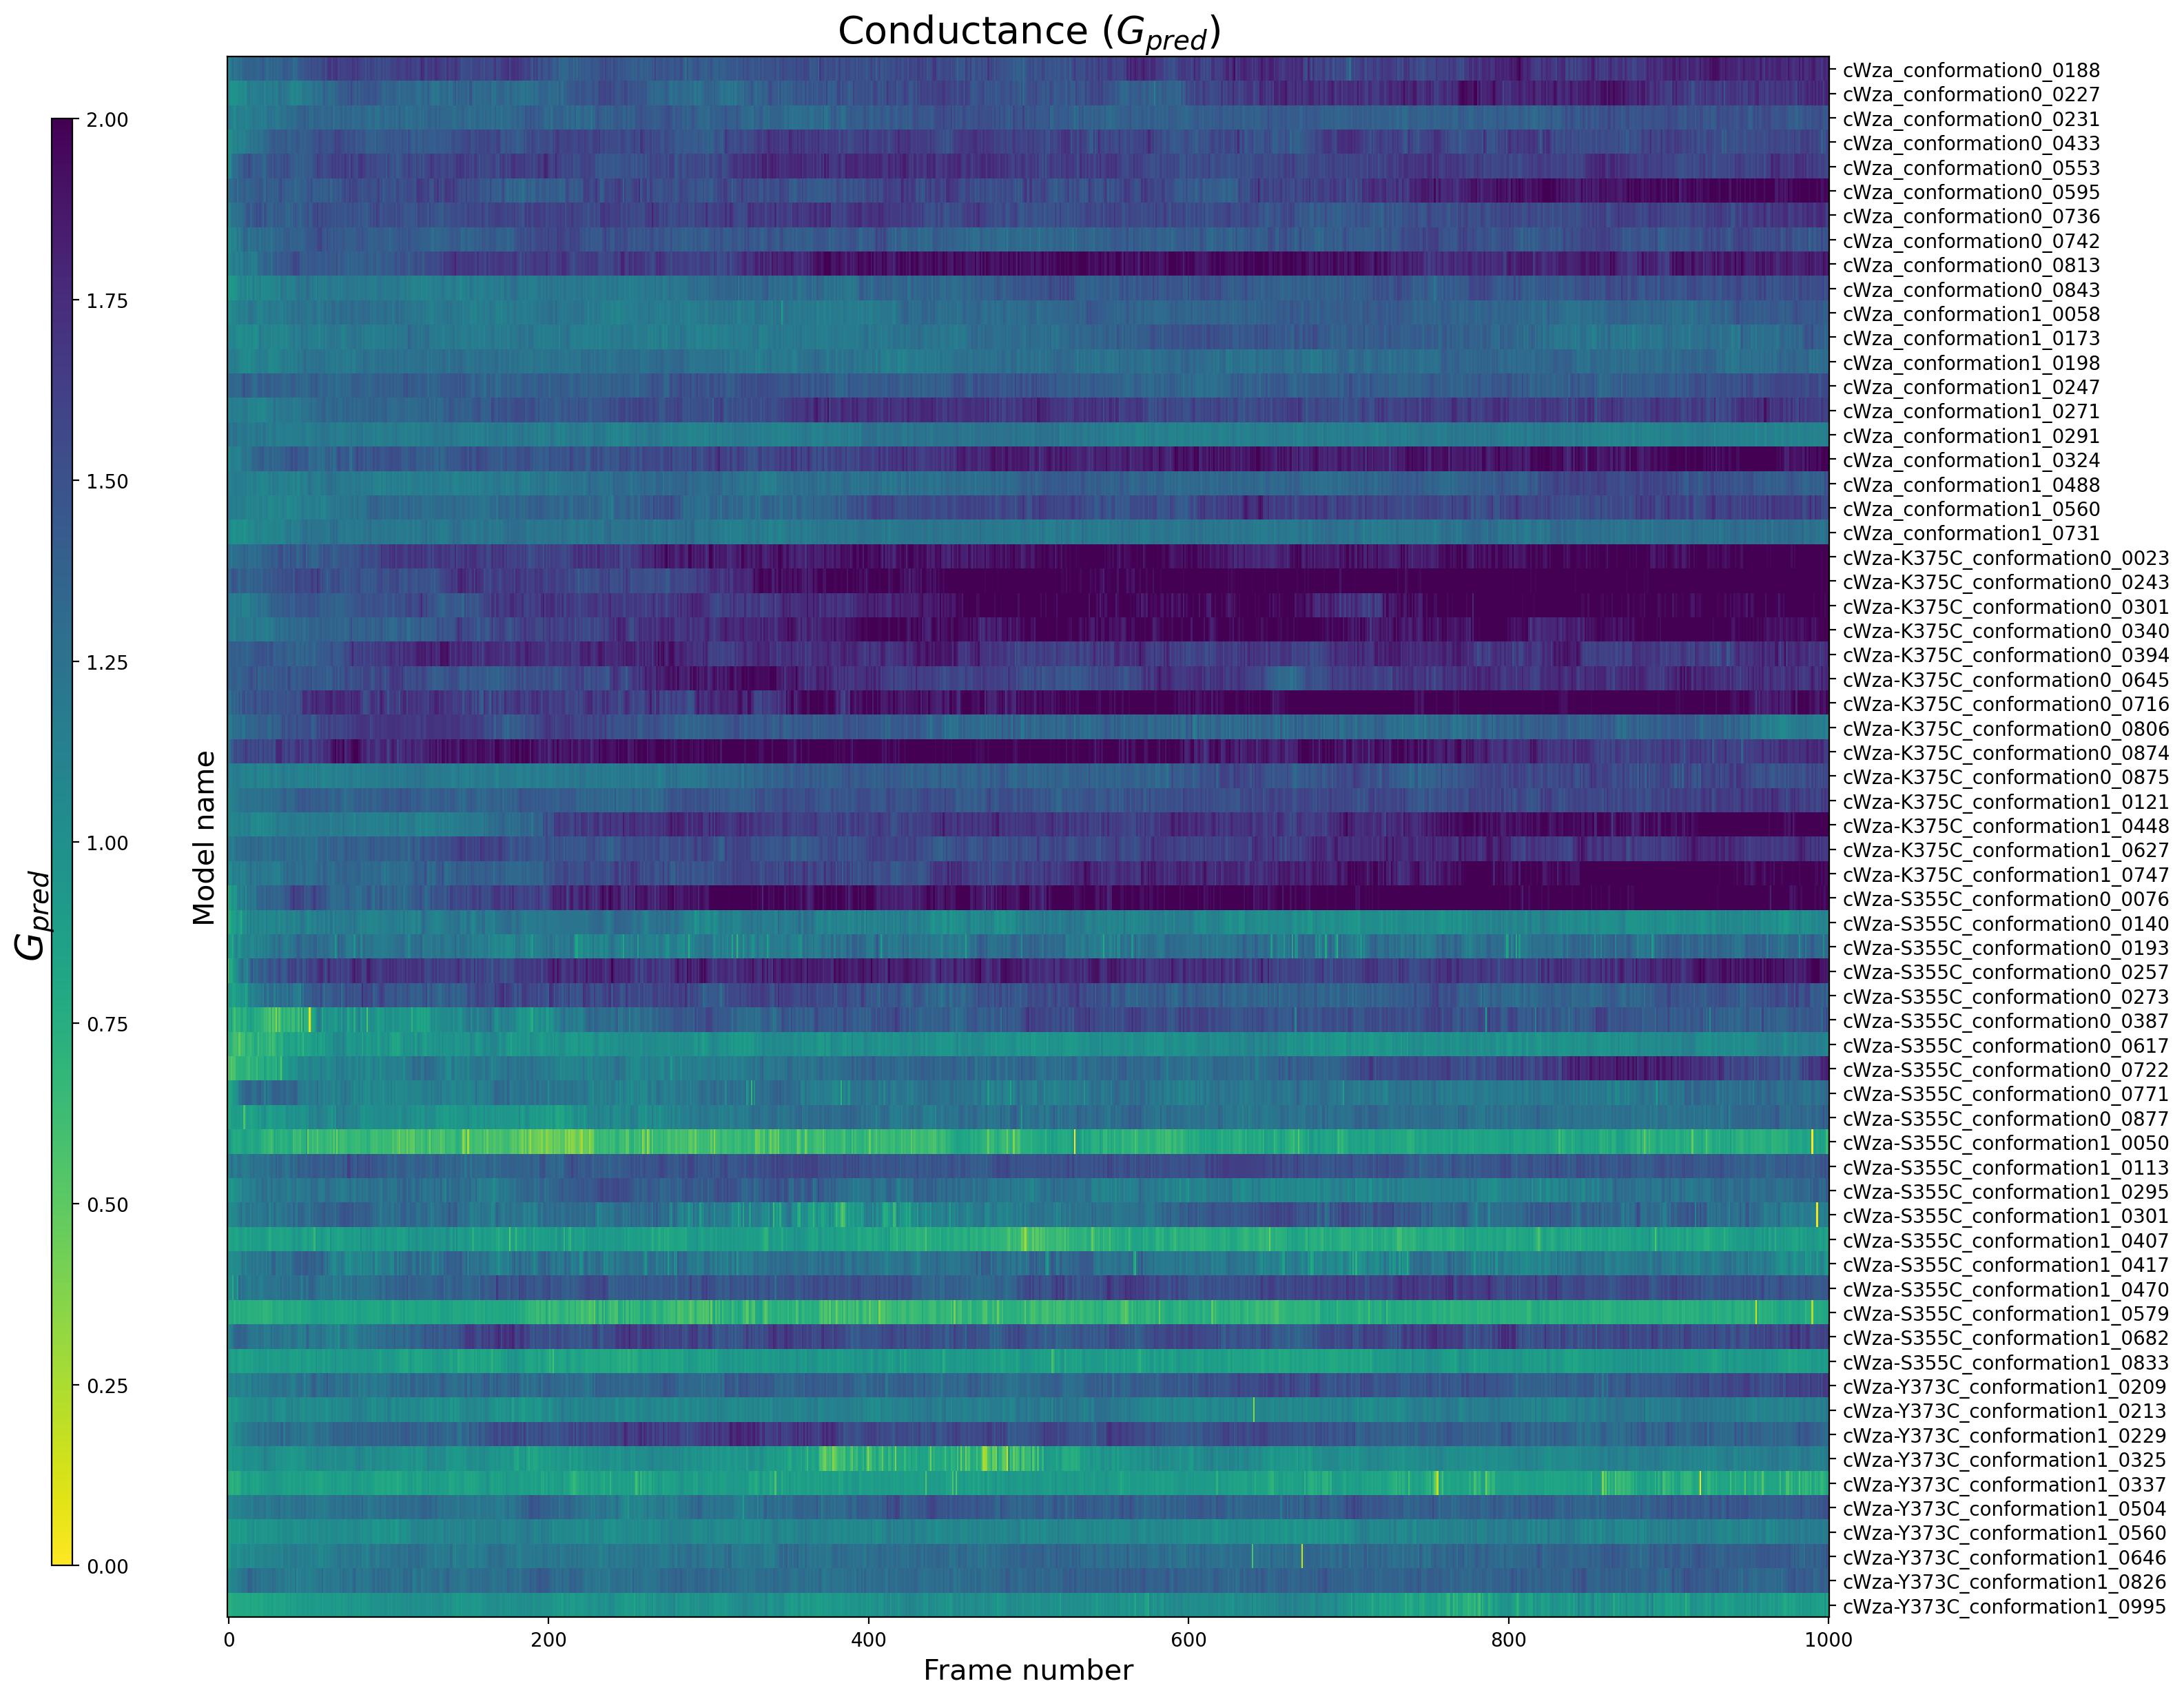

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig,ax = plt.subplots(1,1,figsize=(15,15),dpi=200)
im = ax.imshow(data_matrix, 
               origin='upper', 
               vmin = 0,
               vmax = 2,
               interpolation='nearest',
               aspect='auto',
               cmap='viridis_r',
               alpha=1)

# customise colorbar
cbar_ax = fig.add_axes([0.04, 0.15, 0.01, 0.7])
cbar = plt.colorbar(im, cax=cbar_ax, shrink=0.01)
cbar.set_label('$G_{pred}$', labelpad=-60, y=0.45, fontsize=20)


# custom ylabels
model_names = list(X.keys())
ax.set_yticks(range(len(model_names)))
y_labels = model_names
ax.set_yticklabels(y_labels,fontsize=10)
ax.yaxis.set_tick_params(labelright=True, right=True)
ax.yaxis.set_tick_params(labelleft=False, left=False)

ax.set_title('Conductance ($G_{pred}$)', fontsize=20)
ax.set_xlabel("Frame number", fontsize=15)
ax.set_ylabel("Model name", fontsize=15)

plt.show()

# H-bonds data 

In [23]:
HBA_data = {}
for outdir in dirnames:
    model_name = outdir.split('/')[-1]

    with open(os.path.join(outdir, "md_100ns.hbonds.pickle"),'rb') as fp:
        X = pickle.load(fp)
        
    HBA_data[model_name] = {k:X[k]['time'] for k,v in X.items()}

# Timeseries correlations

TO-DOs

* Rank H-bond data from high to low in terms of total counts
* Compute correlations with this sorted data
* Output/print the identity of these H-bonds along with the correlation and p-value
* Also rank H-bonds from high to low according to correlation and p-value

Proof of concept

In [94]:
from scipy import stats

for outdir in dirnames:
    model_name = outdir.split('/')[-1]

    Y = HOLE_data[model_name]
    
    X = HBA_data[model_name]
    data_matrix = np.array([X[key] for key in X.keys()])
    hbonds_list_sorted = np.array(list(X.keys()))[np.argsort(data_matrix.sum(axis=1))][::-1]
    data_matrix_sorted = data_matrix[np.argsort(data_matrix.sum(axis=1)),:][::-1]
    
    Corr = stats.pearsonr
    YX_correlations = [Corr(Y, data_matrix_sorted[i]) for i in range(len(data_matrix_sorted))]

In [134]:
N_hbonds = len(data_matrix_sorted)
fig,ax = plt.subplots(N_hbonds+1, 1, figsize=(15,24), sharex=True, dpi=200)

#ax[0].plot(stats.zscore(Y), color='orange')
ax[0].plot(Y, color='orange')
ax[0].set_title("Estimated Conductance: "+ model_name)

for i in range(N_hbonds):
    Z = data_matrix_sorted[i]
    #ax[i+1].plot(stats.zscore(Z))
    ax[i+1].plot(Z)
    
    x = hbonds_list_sorted[i]
    title = x[0]+'|||'+x[1]
    ax[i+1].set_title(title)

fig.tight_layout()
p = plt.savefig('data/figs/foo.png', bbox_inches='tight',facecolor='white',transparent=False)
plt.close()

Loop

In [135]:
from scipy import stats

for outdir in dirnames:
    model_name = outdir.split('/')[-1]

    Y = HOLE_data[model_name]
    
    X = HBA_data[model_name]
    data_matrix = np.array([X[key] for key in X.keys()])
    hbonds_list_sorted = np.array(list(X.keys()))[np.argsort(data_matrix.sum(axis=1))][::-1]
    data_matrix_sorted = data_matrix[np.argsort(data_matrix.sum(axis=1)),:][::-1]
    
    Corr = stats.pearsonr
    YX_correlations = [Corr(Y, data_matrix_sorted[i]) for i in range(len(data_matrix_sorted))]

    N_hbonds = len(data_matrix_sorted)
    fig,ax = plt.subplots(N_hbonds+1, 1, figsize=(15,24), sharex=True, dpi=200)

    #ax[0].plot(stats.zscore(Y), color='orange')
    ax[0].plot(Y, color='orange')
    ax[0].set_title("Estimated Conductance: "+ model_name)

    for i in range(N_hbonds):
        Z = data_matrix_sorted[i]
        #ax[i+1].plot(stats.zscore(Z))
        ax[i+1].plot(Z)

        x = hbonds_list_sorted[i]
        title = x[0]+'|||'+x[1]
        ax[i+1].set_title(title)

    fig.tight_layout()
    p = plt.savefig('data/figs/'+model_name+'.png', bbox_inches='tight',facecolor='white',transparent=False)
    plt.close()

Make movie showing data

In [136]:
import imageio

In [146]:
fileList = []
path = 'data/figs/'
name = 'cWza'
for file in os.listdir(path):
    if file.startswith(name):
        complete_path = path + file
        fileList.append(complete_path)

writer = imageio.get_writer('test.mp4')

for im in fileList:
    writer.append_data(imageio.imread(im))
writer.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2980, 4779) to (2992, 4784) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


ValueError: All images in a movie should have same size